# Intro

Good Luck to everyone especially the ones who want to bet against Zion and his Blue devils.

![ZionUrl](https://media.giphy.com/media/54ZSkrYYe8lk9td6r1/giphy.gif "zion")

In this kernel I would like to explore the NCAA data with a quick look at some classical and advanced stats in order to understand which statistics may be more useful for predicting the Ws & Ls in the tournament.

ICYMI: https://stats.nba.com/help/glossary/

Having a detailed information set about every single games of the different seasons, the first step is to create a dataset which contains aggregated stats for each single team.

In [1]:
## > LIBRARIES
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## > DATA
path_datasets = '../input/datafiles/'

df_rs_c_res = pd.read_csv(path_datasets + 'RegularSeasonCompactResults.csv')
df_rs_d_res = pd.read_csv(path_datasets + 'RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'Teams.csv')
df_seeds = pd.read_csv(path_datasets + 'NCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'TeamCoaches.csv')
df_tourn = pd.read_csv(path_datasets + 'NCAATourneyCompactResults.csv')

## Data Cleaning

I basically want to create a unique dataset which uses TeamID as a key. Then aggregate on this particular key every possible metric which seems to be interesting (here just a few).  
Therefore I will end up having regular season statistics which may be helpful in order to predict tournament outcomes.

In [2]:
## > DATA CLEANING
# clean team information

df_teams_cl = df_teams.iloc[:,:2]

## > DATA CLEANING
# clean seed information

df_seeds_cl = df_seeds.loc[:, ['TeamID', 'Season', 'Seed']]

def clean_seed(seed):
    s_int = int(seed[1:3])
    return s_int

def extract_seed_region(seed):
    s_reg = seed[0:1]
    return s_reg

df_seeds_cl['seed_int'] = df_seeds_cl['Seed'].apply(lambda x: clean_seed(x))
df_seeds_cl['seed_region'] = df_seeds_cl['Seed'].apply(lambda x: extract_seed_region(x))
df_seeds_cl['top_seeded_teams'] = np.where(df_seeds_cl['Seed'].isnull(), 0, 1)

df_seeds_cl.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds_cl.head()

,TeamID,Season,seed_int,seed_region,top_seeded_teams
0,1207,1985,1,W,1
1,1210,1985,2,W,1
2,1228,1985,3,W,1
3,1260,1985,4,W,1
4,1374,1985,5,W,1


In [3]:
## > DATA CLEANING
# create games dataframe WINNERS

def new_name_w_1(old_name):
    match = re.match(r'^L', old_name)
    if match:
        out = re.sub('^L','', old_name)
        return out + '_opp'
    return old_name

def new_name_w_2(old_name):
    match = re.match(r'^W', old_name)
    if match:
        out = re.sub('^W','', old_name)
        return out
    return old_name

def prepare_stats_extended_winners(df_in, df_seed_in, df_teams_in):
    df_in['poss'] = df_in['WFGA'] + 0.475*df_in['WFTA'] - df_in['WOR'] + df_in['WTO']
    df_in['opp_poss'] = df_in['LFGA'] + 0.475*df_in['LFTA'] - df_in['LOR'] + df_in['LTO']
    df_in['off_rating'] = 100*(df_in['WScore'] / df_in['poss'])
    df_in['def_rating'] = 100*(df_in['LScore'] / df_in['opp_poss'])
    df_in['net_rating'] = df_in['off_rating'] - df_in['def_rating']
    df_in['pace'] = 48*((df_in['poss']+df_in['opp_poss'])/(2*(240/5)))
    
    df_in = df_in.rename(columns={'WTeamID':'TeamID', 
                                  'WLoc':'_Loc',
                                  'LTeamID':'TeamID_opp',
                                  'WScore':'Score_left', 
                                  'LScore':'Score_right'})
    
    df_seeds_opp = df_seed_in.rename(columns={'TeamID':'TeamID_opp',
                                              'seed_int':'seed_int_opp',
                                              'seed_region':'seed_region_opp',
                                              'top_seeded_teams':'top_seeded_teams_opp'})
    
    df_out = pd.merge(left=df_in, right=df_seeds_cl, how='left', on=['Season', 'TeamID'])
    df_out = pd.merge(left=df_out, right=df_seeds_opp, how='left', on=['Season', 'TeamID_opp'])
    df_out = pd.merge(left=df_out, right=df_teams_in, how='left', on=['TeamID'])
    
    df_out['DayNum'] = pd.to_numeric(df_out['DayNum'])
    df_out['win_dummy'] = 1
    
    df_out['seed_int'] = np.where(df_out['seed_int'].isnull(), 20, df_out['seed_int'])
    df_out['seed_region'] = np.where(df_out['seed_region'].isnull(), 'NoTour', df_out['seed_region'])
    df_out['top_seeded_teams'] = np.where(df_out['top_seeded_teams'].isnull(), 0, df_out['top_seeded_teams'])
    
    df_out['seed_int_opp'] = np.where(df_out['seed_int_opp'].isnull(), 20, df_out['seed_int_opp'])
    df_out['seed_region_opp'] = np.where(df_out['seed_region_opp'].isnull(), 'NoTour', df_out['seed_region_opp'])
    df_out['top_seeded_teams_opp'] = np.where(df_out['top_seeded_teams_opp'].isnull(), 0, df_out['top_seeded_teams_opp'])
    
    df_out = df_out.rename(columns=new_name_w_1)
    df_out = df_out.rename(columns=new_name_w_2)
    
    return df_out

df_games_w = prepare_stats_extended_winners(df_rs_d_res, df_seeds_cl, df_teams_cl)

df_games_w.head()

,Season,DayNum,TeamID,Score_left,TeamID_opp,Score_right,_Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGM_opp,FGA_opp,FGM3_opp,FGA3_opp,FTM_opp,FTA_opp,OR_opp,DR_opp,Ast_opp,TO_opp,Stl_opp,Blk_opp,PF_opp,poss,opp_poss,off_rating,def_rating,net_rating,pace,seed_int,seed_region,top_seeded_teams,seed_int_opp,seed_region_opp,top_seeded_teams_opp,TeamName,win_dummy
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,75.550,71.450,90.006618,86.773968,3.232650,73.5000,10.0,Y,1.0,1.0,W,1.0,Alabama,1
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,69.025,68.500,101.412532,91.970803,9.441729,68.7625,7.0,Z,1.0,3.0,W,1.0,Memphis,1
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,64.775,64.925,112.697800,93.954563,18.743237,64.8500,3.0,Y,1.0,20.0,NoTour,0.0,Marquette,1
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,58.725,58.125,95.359728,86.021505,9.338222,58.4250,20.0,NoTour,0.0,20.0,NoTour,0.0,N Illinois,1
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,64.175,63.825,119.984418,111.241676,8.742741,64.0000,1.0,X,1.0,20.0,NoTour,0.0,Texas,1


In [4]:
## > DATA CLEANING
# create games dataframe LOSERS

def new_name_l_1(old_name):
    match = re.match(r'^W', old_name)
    if match:
        out = re.sub('^W','', old_name)
        return out + '_opp'
    return old_name

def new_name_l_2(old_name):
    match = re.match(r'^L', old_name)
    if match:
        out = re.sub('^L','', old_name)
        return out
    return old_name

def prepare_stats_extended_losers(df_in, df_seed_in, df_teams_in):
    df_in['poss'] = df_in['LFGA'] + (0.475*df_in['LFTA']) - df_in['LOR'] + df_in['LTO']
    df_in['opp_poss'] = df_in['WFGA'] + (0.475*df_in['WFTA']) - df_in['WOR'] + df_in['WTO']
    df_in['off_rating'] = 100*(df_in['LScore'] / df_in['poss'])
    df_in['def_rating'] = 100*(df_in['WScore'] / df_in['opp_poss'])
    df_in['net_rating'] = df_in['off_rating'] - df_in['def_rating']
    df_in['pace'] = 48*((df_in['poss']+df_in['opp_poss'])/(2*(240/5)))
    
    df_in = df_in.rename(columns={'LTeamID':'TeamID', 
                                  'LLoc':'_Loc',
                                  'WTeamID':'TeamID_opp',
                                  'LScore':'Score_left', 
                                  'WScore':'Score_right'})
    
    df_seeds_opp = df_seed_in.rename(columns={'TeamID':'TeamID_opp',
                                              'seed_int':'seed_int_opp',
                                              'seed_region':'seed_region_opp',
                                              'top_seeded_teams':'top_seeded_teams_opp'})
    
    df_out = pd.merge(left=df_in, right=df_seeds_cl, how='left', on=['Season', 'TeamID'])
    df_out = pd.merge(left=df_out, right=df_seeds_opp, how='left', on=['Season', 'TeamID_opp'])
    df_out = pd.merge(left=df_out, right=df_teams_in, how='left', on=['TeamID'])
    
    df_out['DayNum'] = pd.to_numeric(df_out['DayNum'])
    df_out['win_dummy'] = 0
    
    df_out['seed_int'] = np.where(df_out['seed_int'].isnull(), 20, df_out['seed_int'])
    df_out['seed_region'] = np.where(df_out['seed_region'].isnull(), 'NoTour', df_out['seed_region'])
    df_out['top_seeded_teams'] = np.where(df_out['top_seeded_teams'].isnull(), 0, df_out['top_seeded_teams'])
    
    df_out['seed_int_opp'] = np.where(df_out['seed_int_opp'].isnull(), 20, df_out['seed_int_opp'])
    df_out['seed_region_opp'] = np.where(df_out['seed_region_opp'].isnull(), 'NoTour', df_out['seed_region_opp'])
    df_out['top_seeded_teams_opp'] = np.where(df_out['top_seeded_teams_opp'].isnull(), 0, df_out['top_seeded_teams_opp'])

    df_out = df_out.rename(columns=new_name_l_1)
    df_out = df_out.rename(columns=new_name_l_2)
    
    return df_out

df_games_l = prepare_stats_extended_losers(df_rs_d_res, df_seeds_cl, df_teams_cl)

df_games_l.head()

,Season,DayNum,TeamID_opp,Score_right,TeamID,Score_left,oc_opp,NumOT,FGM_opp,FGA_opp,FGM3_opp,FGA3_opp,FTM_opp,FTA_opp,OR_opp,DR_opp,Ast_opp,TO_opp,Stl_opp,Blk_opp,PF_opp,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,poss,opp_poss,off_rating,def_rating,net_rating,pace,seed_int,seed_region,top_seeded_teams,seed_int_opp,seed_region_opp,top_seeded_teams_opp,TeamName,win_dummy
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,71.450,75.550,86.773968,90.006618,-3.232650,73.5000,1.0,W,1.0,10.0,Y,1.0,Oklahoma,0
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,68.500,69.025,91.970803,101.412532,-9.441729,68.7625,3.0,W,1.0,7.0,Z,1.0,Syracuse,0
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,64.925,64.775,93.954563,112.697800,-18.743237,64.8500,20.0,NoTour,0.0,3.0,Y,1.0,Villanova,0
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,58.125,58.725,86.021505,95.359728,-9.338222,58.4250,20.0,NoTour,0.0,20.0,NoTour,0.0,Winthrop,0
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,63.825,64.175,111.241676,119.984418,-8.742741,64.0000,20.0,NoTour,0.0,1.0,X,1.0,Georgia,0


In [5]:
## > MERGE

df_games_t = pd.concat([df_games_w,df_games_l], sort=True)

## > AGGREGATED STATS BY TEAM AND SEASON

def aggr_stats(df):
    d = {}
    d['G'] = df['win_dummy'].count()
    d['W'] = df['win_dummy'].sum()
    d['L'] = np.sum(df['win_dummy'] == 0)
    d['G_vs_topseeds'] = np.sum(df['top_seeded_teams_opp'] == 1)
    d['W_vs_topseeds'] = np.sum((df['win_dummy'] == 1) & (df['top_seeded_teams_opp'] == 1))
    d['L_vs_topseeds'] = np.sum((df['win_dummy'] == 0) & (df['top_seeded_teams_opp'] == 1))
    d['G_last30D'] = np.sum((df['DayNum'] > 100))
    d['W_last30D'] = np.sum((df['win_dummy'] == 1) & (df['DayNum'] > 100))
    d['L_last30D'] = np.sum((df['win_dummy'] == 0) & (df['DayNum'] > 100))
    d['G_H'] = np.sum((df['_Loc'] == 'H'))
    d['W_H'] = np.sum((df['win_dummy'] == 1) & (df['_Loc'] == 'H'))
    d['L_H'] = np.sum((df['win_dummy'] == 0) & (df['_Loc'] == 'H'))
    d['G_A'] = np.sum((df['_Loc'] == 'A'))
    d['W_A'] = np.sum((df['win_dummy'] == 1) & (df['_Loc'] == 'A'))
    d['L_A'] = np.sum((df['win_dummy'] == 0) & (df['_Loc'] == 'A'))
    d['G_N'] = np.sum((df['_Loc'] == 'N'))
    d['W_N'] = np.sum((df['win_dummy'] == 1) & (df['_Loc'] == 'N'))
    d['L_N'] = np.sum((df['win_dummy'] == 0) & (df['_Loc'] == 'N'))
    
    d['PS'] = np.mean(df['Score_left'])
    d['PS_H'] = np.mean(df['Score_left'][df['_Loc'] == 'H'])
    d['PS_A'] = np.mean(df['Score_left'][df['_Loc'] == 'A'])
    d['PS_N'] = np.mean(df['Score_left'][df['_Loc'] == 'N'])
    d['PS_last30D'] = np.mean(df['Score_left'][df['DayNum'] > 100])
    
    d['PA'] = np.mean(df['Score_right'])
    d['PA_H'] = np.mean(df['Score_right'][df['_Loc'] == 'H'])
    d['PA_A'] = np.mean(df['Score_right'][df['_Loc'] == 'A'])
    d['PA_N'] = np.mean(df['Score_right'][df['_Loc'] == 'N'])
    d['PA_last30D'] = np.mean(df['Score_right'][df['DayNum'] > 100])
    
    d['poss_m'] = np.mean(df['poss'])
    d['opp_poss_m'] = np.mean(df['opp_poss'])
    d['off_rating_m'] = np.mean(df['off_rating'])
    d['def_rating_m'] = np.mean(df['def_rating'])
    d['net_rating_m'] = np.mean(df['net_rating'])
    d['pace_m'] = np.mean(df['pace'])
    
    d['off_rating_m_last30D'] = np.mean(df['off_rating'][df['DayNum'] > 100])
    d['def_rating_m_last30D'] = np.mean(df['def_rating'][df['DayNum'] > 100])
    d['net_rating_m_last30D'] = np.mean(df['net_rating'][df['DayNum'] > 100])
    
    d['off_rating_m_vs_topseeds'] = np.mean(df['off_rating'][df['top_seeded_teams_opp'] == 1])
    d['def_rating_m_vs_topseeds'] = np.mean(df['def_rating'][df['top_seeded_teams_opp'] == 1])
    d['net_rating_m_vs_topseeds'] = np.mean(df['net_rating'][df['top_seeded_teams_opp'] == 1])
    
    return pd.Series(d)


df_agg_stats = df_games_t.\
                          groupby([df_games_t['Season'], 
                                   df_games_t['TeamID'],
                                   df_games_t['TeamName'],
                                   df_games_t['seed_int'],
                                   df_games_t['seed_region']], 
                                  as_index=False).\
                          apply(aggr_stats).\
                          reset_index()


df_agg_stats['w_pct'] = df_agg_stats['W'] / df_agg_stats['G']
df_agg_stats['w_pct_last30D'] = df_agg_stats['W_last30D'] / df_agg_stats['G_last30D']
df_agg_stats['w_pct_vs_topseeds'] = df_agg_stats['W_vs_topseeds'] / df_agg_stats['G_vs_topseeds']

df_agg_stats.head(20)

/opt/conda/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,L_vs_topseeds,G_last30D,W_last30D,L_last30D,G_H,W_H,L_H,G_A,W_A,L_A,G_N,W_N,L_N,PS,PS_H,PS_A,PS_N,PS_last30D,PA,PA_H,PA_A,PA_N,PA_last30D,poss_m,opp_poss_m,off_rating_m,def_rating_m,net_rating_m,pace_m,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds
0,2003,1102,Air Force,20.0,NoTour,28.0,12.0,16.0,8.0,1.0,7.0,8.0,2.0,6.0,9.0,9.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,57.250000,70.555556,63.333333,NaN,57.625000,57.000000,53.888889,51.000000,NaN,61.875000,55.161607,54.929464,103.754717,103.815398,-0.060681,55.045536,103.480479,113.001910,-9.521431,86.069266,106.075033,-20.005767,0.428571,0.250000,0.125000
1,2003,1103,Akron,20.0,NoTour,27.0,13.0,14.0,2.0,1.0,1.0,7.0,4.0,3.0,9.0,9.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,78.777778,88.555556,86.000000,NaN,73.428571,78.148148,77.333333,80.750000,NaN,70.857143,70.983333,70.816667,110.565133,110.627622,-0.062489,70.900000,112.243185,108.383990,3.859194,108.428135,112.513155,-4.085020,0.481481,0.571429,0.500000
2,2003,1104,Alabama,10.0,Y,28.0,17.0,11.0,11.0,5.0,6.0,8.0,4.0,4.0,13.0,13.0,0.0,1.0,1.0,0.0,3.0,3.0,0.0,69.285714,76.923077,76.000000,64.666667,72.875000,65.000000,61.692308,71.000000,57.666667,67.750000,66.833929,66.607143,103.369974,98.055068,5.314906,66.720536,108.858455,103.367799,5.490656,95.831973,98.942661,-3.110688,0.607143,0.500000,0.454545
3,2003,1105,Alabama A&M,20.0,NoTour,26.0,7.0,19.0,4.0,1.0,3.0,8.0,2.0,6.0,5.0,5.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,71.769231,85.000000,65.500000,NaN,78.625000,76.653846,68.400000,61.500000,NaN,77.250000,77.146154,76.214423,92.999174,100.981886,-7.982712,76.680288,100.559264,99.375646,1.183618,93.914723,114.009555,-20.094831,0.269231,0.250000,0.250000
4,2003,1106,Alabama St,20.0,NoTour,28.0,13.0,15.0,5.0,1.0,4.0,8.0,3.0,5.0,8.0,8.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,63.607143,71.250000,63.600000,NaN,61.625000,63.750000,57.625000,58.400000,NaN,64.375000,67.856250,67.575893,93.648220,94.460182,-0.811962,67.716071,90.181382,96.510427,-6.329045,91.396758,107.826954,-16.430197,0.464286,0.375000,0.200000
5,2003,1107,Albany NY,20.0,NoTour,28.0,7.0,21.0,5.0,0.0,5.0,7.0,2.0,5.0,5.0,5.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,65.928571,71.600000,67.000000,NaN,65.285714,75.714286,67.400000,61.000000,NaN,73.571429,68.215179,69.087500,96.408152,109.292214,-12.884063,68.651339,99.008771,110.505500,-11.496729,93.020945,121.364230,-28.343285,0.250000,0.285714,0.000000
6,2003,1108,Alcorn St,20.0,NoTour,33.0,14.0,19.0,4.0,0.0,4.0,10.0,6.0,4.0,7.0,7.0,0.0,5.0,5.0,0.0,2.0,2.0,0.0,69.090909,82.428571,65.600000,72.500000,68.000000,73.121212,71.000000,60.600000,60.000000,67.400000,74.006818,74.115152,93.573643,98.364995,-4.791352,74.060985,97.043373,96.122939,0.920434,92.454294,108.171290,-15.716996,0.424242,0.600000,0.000000
7,2003,1110,American Univ,20.0,NoTour,30.0,16.0,14.0,6.0,1.0,5.0,8.0,5.0,3.0,11.0,11.0,0.0,3.0,3.0,0.0,2.0,2.0,0.0,66.366667,71.454545,71.666667,73.000000,70.000000,61.900000,55.454545,64.000000,56.000000,59.500000,64.553333,64.486667,103.163710,96.311833,6.851876,64.520000,111.619320,96.308492,15.310828,99.158826,106.486402,-7.327576,0.533333,0.625000,0.166667
8,2003,1111,Appalachian St,20.0,NoTour,26.0,16.0,10.0,3.0,1.0,2.0,7.0,3.0,4.0,9.0,9.0,0.0,6.0,6.0,0.0,1.0,1.0,0.0,83.269231,92.000000,84.833333,73.000000,77.428571,81.730769,75.777778,77.333333,63.000000,84.428571,80.133654,80.156731,104.029477,102.090296,1.939181,80.145192,99.004098,107.661483,-8.657385,99.855737,108.868313,-9.012576,0.615385,0.428571,0.333333
9,2003,1112,Arizona,1.0,Z,28.0,25.0,3.0,12.0,10.0,2.0,8.0,7.0,1.0,14.0,14.0,0.0,11.0,11.0,0.0,0.0,0.0,0.0,85.214286,87.928571,84.000000,NaN,86.625000,70.250000,67.428571,70.818182,NaN,72.625000,77.196429,76.842857,110.623626,91.782211,18.841415,77.019643,114.078080,95.884574,18.193506,112.715440,98.524430,14.191009,0.892857,0.875000,0.833333


In [6]:
## > DATA CLEANING 

# prepare tournament dataset
def prepare_tournament_datasets(df_tourn_in, df_agg_stats_in):
    
    df_tourn_in['TeamID'] = df_tourn_in[['WTeamID','LTeamID']].min(axis=1)
    df_tourn_in['TeamID_opp'] = df_tourn_in[['WTeamID','LTeamID']].max(axis=1)
    df_tourn_in['win_dummy'] = np.where(df_tourn_in['TeamID'] == df_tourn_in['WTeamID'], 1, 0)
    df_tourn_in['delta'] = np.where(df_tourn_in['win_dummy'] == 1,
                                    df_tourn_in['WScore'] - df_tourn['LScore'],
                                    df_tourn_in['LScore'] - df_tourn['WScore'])
    df_tourn_in['Score_left'] = np.where(df_tourn_in['win_dummy'] == 1,
                                         df_tourn_in['WScore'],
                                         df_tourn_in['LScore'])
    df_tourn_in['Score_right'] = np.where(df_tourn_in['win_dummy'] == 1,
                                          df_tourn_in['LScore'],
                                          df_tourn_in['WScore'])
                                 
    df_teams_gr_left = df_agg_stats_in.loc[:,['Season', 'TeamID',
                                              'w_pct', 'seed_int', 
                                              'net_rating_m_last30D',
                                              'net_rating_m_vs_topseeds',
                                              'net_rating_m']].\
                  rename(columns={'w_pct':'w_pct_left',
                                  'seed_int':'seed_int_left', 
                                  'net_rating_m_last30D':'net_rating_m_last30D_left', 
                                  'net_rating_m_vs_topseeds':'net_rating_m_vs_topseeds_left', 
                                  'net_rating_m':'net_rating_m_left'})
    
    df_teams_gr_right = df_agg_stats_in.loc[:,['Season', 'TeamID',
                                               'w_pct', 'seed_int',
                                               'net_rating_m_last30D',
                                               'net_rating_m_vs_topseeds',
                                               'net_rating_m']].\
                  rename(columns={'TeamID':'TeamID_opp',
                                  'w_pct':'w_pct_right',
                                  'seed_int':'seed_int_right', 
                                  'net_rating_m_last30D':'net_rating_m_last30D_right', 
                                  'net_rating_m_vs_topseeds':'net_rating_m_vs_topseeds_right', 
                                  'net_rating_m':'net_rating_m_right'})
    
    df_tourn_out = pd.merge(left=df_tourn_in, 
                            right=df_teams_gr_left, 
                            how='left', on=['Season', 'TeamID'])
    df_tourn_out = pd.merge(left=df_tourn_out, 
                            right=df_teams_gr_right, 
                            how='left', on=['Season', 'TeamID_opp'])

    df_tourn_out['delta_w_pct'] = df_tourn_out['w_pct_left'] - \
                                         df_tourn_out['w_pct_right']


    df_tourn_out['delta_seed_int'] = df_tourn_out['seed_int_left'] - \
                                          df_tourn_out['seed_int_right']


    df_tourn_out['delta_net_rating_m'] = df_tourn_out['net_rating_m_left'] - df_tourn_out['net_rating_m_right']
    
    df_tourn_out['delta_net_rating_m_last30D'] = df_tourn_out['net_rating_m_last30D_left'] - df_tourn_out['net_rating_m_last30D_right']
    
    df_tourn_out['delta_net_rating_m_vs_topseeds'] = df_tourn_out['net_rating_m_vs_topseeds_left'] - df_tourn_out['net_rating_m_vs_topseeds_right']
    
    df_out = df_tourn_out.loc[:, ['Season', 'DayNum',
                                  'TeamID', 'TeamID_opp',
                                  'Score_left', 'Score_right',
                                  'win_dummy', 
                                  'delta', 'NumOT', 'delta_w_pct', 
                                  'delta_net_rating_m_last30D',
                                  'delta_net_rating_m_vs_topseeds',
                                  'delta_net_rating_m', 'delta_seed_int']]
                                    
    return df_out

                                    
df_tourn_cl = prepare_tournament_datasets(df_tourn, df_agg_stats)                                    
df_tourn_cl[(df_tourn_cl['Season'].isin([2015, 2016, 2017, 2018]))].head(10)

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_w_pct,delta_net_rating_m_last30D,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int
1916,2015,134,1214,1264,74,64,1,10,0,-0.108902,-3.018064,-7.095915,-6.245560,0.0
1917,2015,134,1140,1279,90,94,0,-4,0,0.093750,14.291291,-7.255070,5.312054,0.0
1918,2015,135,1129,1173,55,56,0,-1,0,-0.015640,9.289018,3.998353,2.869640,0.0
1919,2015,135,1316,1352,77,81,0,-4,0,0.069404,3.087852,20.035697,6.546832,0.0
1920,2015,136,1112,1411,93,72,1,21,0,0.264706,15.607759,47.288389,25.330178,-13.0
1921,2015,136,1116,1459,56,53,1,3,0,-0.047794,-15.115941,24.764975,-0.545609,-7.0
1922,2015,136,1139,1400,56,48,1,8,0,0.081439,-1.820575,4.963689,1.785252,-5.0
1923,2015,136,1153,1345,66,65,1,1,1,0.051136,10.622481,8.747532,4.294895,-1.0
1924,2015,136,1186,1207,74,84,0,-10,0,0.064516,-0.409361,9.206828,-2.112576,9.0
1925,2015,136,1124,1209,56,57,0,-1,0,0.000000,-12.433592,40.943605,-0.553387,-11.0


## Quick exploration of Duke Team in 2018

Here's a quick overview of the Blue Devils performance in 2018.

In [7]:
## > DUKE RS
df_agg_stats[(df_agg_stats['TeamName'] == 'Duke') & (df_agg_stats['Season'] == 2018)].head()

,Season,TeamID,TeamName,seed_int,seed_region,G,W,L,G_vs_topseeds,W_vs_topseeds,L_vs_topseeds,G_last30D,W_last30D,L_last30D,G_H,W_H,L_H,G_A,W_A,L_A,G_N,W_N,L_N,PS,PS_H,PS_A,PS_N,PS_last30D,PA,PA_H,PA_A,PA_N,PA_last30D,poss_m,opp_poss_m,off_rating_m,def_rating_m,net_rating_m,pace_m,off_rating_m_last30D,def_rating_m_last30D,net_rating_m_last30D,off_rating_m_vs_topseeds,def_rating_m_vs_topseeds,net_rating_m_vs_topseeds,w_pct,w_pct_last30D,w_pct_vs_topseeds
5204,2018,1181,Duke,2.0,X,33.0,26.0,7.0,14.0,9.0,5.0,10.0,7.0,3.0,15.0,15.0,0.0,6.0,6.0,0.0,5.0,5.0,0.0,84.69697,89.2,81.833333,89.4,73.4,69.606061,63.2,67.333333,78.8,63.2,71.262879,71.358333,118.719816,97.253915,21.465901,71.310606,109.837792,92.985954,16.851837,108.78899,100.517885,8.271105,0.787879,0.7,0.642857


In [8]:
## > DUKE TOURNAMENT
df_tourn_cl[((df_tourn_cl['TeamID'] == 1181) | (df_tourn_cl['TeamID_opp'] == 1181)) & \
            (df_tourn_cl['Season'] == 2018)].head(10)

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_w_pct,delta_net_rating_m_last30D,delta_net_rating_m_vs_topseeds,delta_net_rating_m,delta_seed_int
2123,2018,136,1181,1233,89,67,1,22,0,0.181818,15.202955,18.914378,16.608410,-13.0
2153,2018,138,1181,1348,87,62,1,25,0,0.006629,11.469808,6.569660,9.415666,-5.0
2173,2018,144,1181,1393,69,65,1,4,0,0.181818,20.263354,11.886725,15.883485,-9.0
2179,2018,146,1181,1242,81,85,0,-4,1,-0.006239,7.321788,-6.286422,6.982901,1.0


## DATA VISUALIZATION

Here I want to explore:
1. Distribution of net ratings during regular season 
2. Boxplots of net rating applied to Tournament in order to predict game's outcome
3. Correlation plot

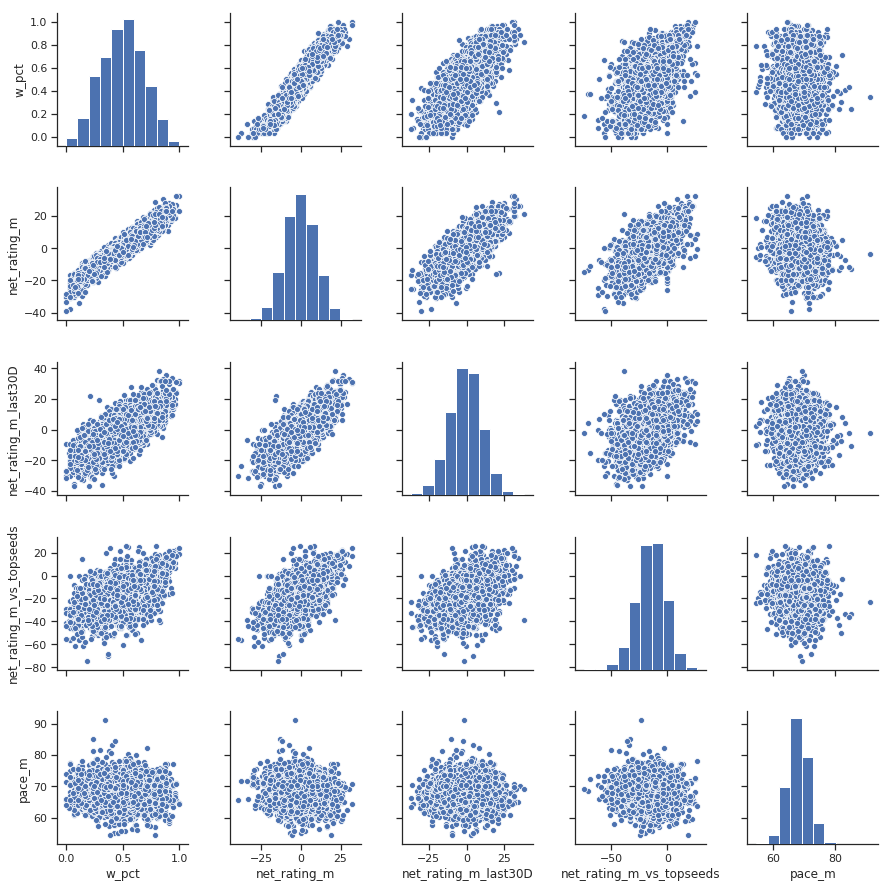

In [9]:
## > DATA VIZ RS
sns.set(style="ticks", color_codes=True)

df_teams_gr = df_agg_stats.loc[:,['w_pct',
                                  'net_rating_m', 'net_rating_m_last30D', 
                                  'net_rating_m_vs_topseeds', 'pace_m']]

df_teams_gr = df_teams_gr.fillna(0)

#df_teams_gr.describe()
sns.pairplot(df_teams_gr, palette="Set1")

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

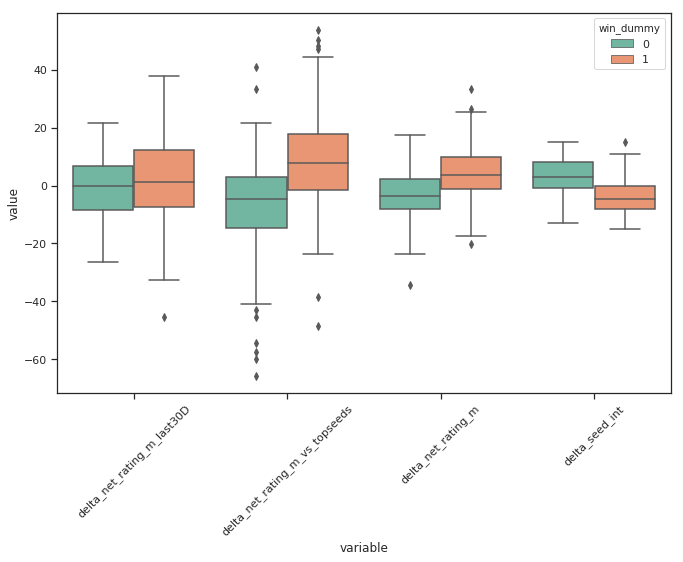

In [10]:
## > DATA VIZ TOURNEY
sns.set(style="ticks", color_codes=True)

df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin([2015, 2016, 2017, 2018]))].reindex()

df_tourn_cl_gr = df_tourn_cl_gr.loc[:,['win_dummy',
                                       'delta_net_rating_m_last30D',
                                       'delta_net_rating_m_vs_topseeds',
                                       'delta_net_rating_m',  
                                       'delta_seed_int']]

fig, ax = plt.subplots(figsize=(11, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr, id_vars='win_dummy'), palette="Set2")
plt.xticks(rotation=45)

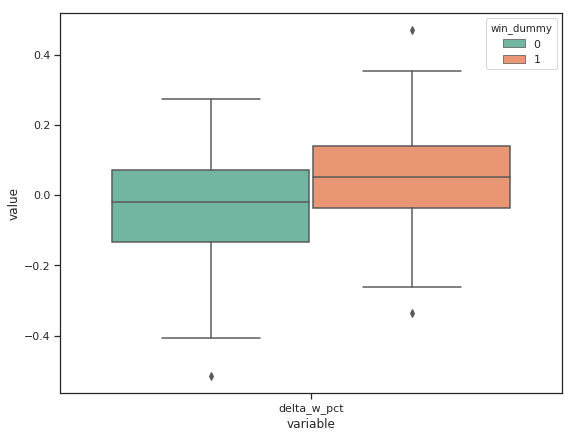

In [11]:
## > DATA VIZ TOURNEY
df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin([2015, 2016, 2017, 2018]))].reindex()

df_tourn_cl_gr = df_tourn_cl_gr.loc[:,['win_dummy',
                                       'delta_w_pct']]

fig, ax = plt.subplots(figsize=(9, 7))
sns.boxplot(x="variable", y="value", hue = 'win_dummy', ax=ax, 
            data=pd.melt(df_tourn_cl_gr, id_vars='win_dummy'), palette="Set2")

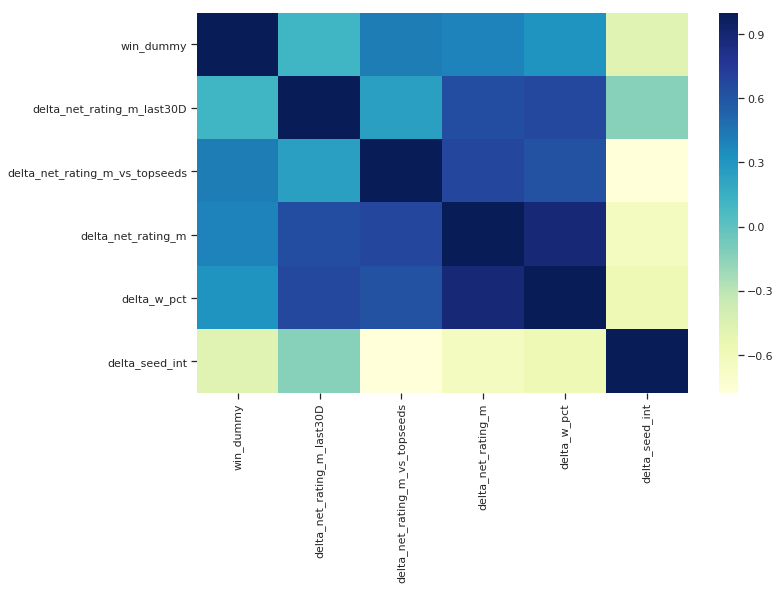

In [12]:
## > Correlation
# Compute the correlation matrix
df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin([2015, 2016, 2017, 2018]))].reindex()

df_tourn_cl_gr = df_tourn_cl_gr.loc[:,['win_dummy',
                                       'delta_net_rating_m_last30D',
                                       'delta_net_rating_m_vs_topseeds',                                       
                                       'delta_net_rating_m',  
                                       'delta_w_pct',
                                       'delta_seed_int']].fillna(0)

corr = df_tourn_cl_gr.corr()
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, cmap="YlGnBu", ax = ax)

In [13]:
## > AR
def somers2_py(x, y):
    
    from sklearn.metrics import roc_auc_score
    
    C = roc_auc_score(y, x)
    Dxy = (2 * roc_auc_score(y, x))  - 1
    
    return Dxy, C

def apply_somers(df):
    
    d = {}
    
    dxy, cxy = somers2_py(df['value'],
                          df['win_dummy'])
    
    d['Dxy'] = dxy
    d['C'] = cxy
    
    
    return pd.Series(d)

df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin([2015, 2016, 2017, 2018]))].reindex()

df_tourn_cl_gr = df_tourn_cl_gr.loc[:,['win_dummy',
                                       'delta_net_rating_m_last30D',
                                       'delta_net_rating_m_vs_topseeds',                                       
                                       'delta_net_rating_m',  
                                       'delta_w_pct',
                                       'delta_seed_int']].fillna(0)

df_ar = pd.melt(df_tourn_cl_gr, id_vars='win_dummy')

df_ar.groupby(['variable']).\
                          apply(apply_somers).\
                          reset_index().\
                          sort_values(by=['Dxy'], ascending=False)

,variable,Dxy,C
2,delta_net_rating_m_vs_topseeds,0.516241,0.758121
0,delta_net_rating_m,0.457325,0.728663
4,delta_w_pct,0.343022,0.671511
1,delta_net_rating_m_last30D,0.109767,0.554884
3,delta_seed_int,-0.561324,0.219338


## Conclusion
As all of you may have noticed the general and against top-seeded stats seems to display a low correlation with the seeds and high accuracy levels. Which could be good for modeling.  
Unluckily instead, the last 30 days of the regular season seems to do not have high levels of accuracy; however, this information may become useful in order to predict the outcome of the first games of the tournament.

![ZionDunkUrl](https://media.giphy.com/media/3MbRQm86C13FvUAyWV/giphy.gif "zionDunk")

Hope you guys have enjoyed this first dive into the NCAA data. I would probably add some relevant metrics in order to extend the number of regressors in future models.

I would like to hear from you if you have some comments and if someone would like to suggest some other advanced statistics which I missed and may have some predictive power.

If you liked the kernel (or simply loved the Zion gifs) please remember to upvote. ;)